In [1]:
from train import *
from model import *

import os
import plac
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

import numpy as np
from PIL import Image

import torch
from torch import nn, Tensor
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision.utils import make_grid
import torchvision.utils as vutils

num GPUs 2
num GPUs 2


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 2


In [3]:
names = []
images = []
image_size = (3, 128, 128)
fill_color = (255, 255, 255)
num_of_low_shots = 24
num_of_val = 8*8

for img in os.listdir('./pokemon/images/images'):
    im = Image.open('./pokemon/images/images/{}'.format(img))
    names.append(img.split('.')[0])
    im = im.convert("RGBA")
    if im.mode in ('RGBA', 'LA'):
        bg = Image.new(im.mode[:-1], image_size[1:], fill_color) # size = (128, 128, 3)
        bg.paste(im, im.split()[-1])
        im = bg

    images.append(np.asarray(im))
    if len(images) == 800: # crop at 800 images
        break
    
images = (np.asarray(images).astype(np.float32) / 255.0)/ 2. + 0.5

In [4]:
batch_size = 2
    
train_set = Pokeman(images[:num_of_low_shots], names[:num_of_low_shots])
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, 
    shuffle=True, num_workers=8, pin_memory=False,
)


val_set = Pokeman(images[-num_of_val:], names[-num_of_val:])
val_loader = torch.utils.data.DataLoader(val_set, shuffle=False, batch_size=1)
len(train_set)

24

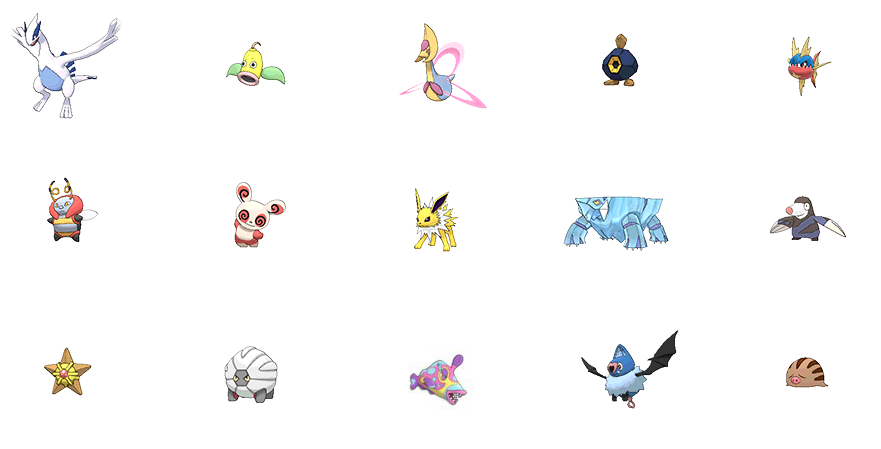

In [5]:
plt.figure(figsize=(16, 8))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    image, _, _ = val_loader.dataset.__getitem__(i)
    to_plot = image.numpy().transpose((1, 2, 0))
    plt.imshow(to_plot)
    plt.axis('off');

In [6]:
code_dim = 128
Z = np.random.normal(size=(len(train_set), 1, code_dim)).astype(np.float32) # (number of low shots, 128)
Z = torch.tensor(Z, requires_grad=True).to(device)

In [7]:
LV_Z = LatentVariables(Z).to(device)
pre_decoder = Decoder(code_dim).to(device)

g = CombinedModel(LV_Z, pre_decoder).to(device)
g.apply(weight_init)
print(get_n_params(g))
print(g)

13248384
CombinedModel(
  (Z): LatentVariables()
  (Decoder): Decoder(
    (dcnn): Sequential(
      (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(

In [8]:
# prepare for pre-train
loss_fn = nn.MSELoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(g.parameters(), lr=learning_rate)

Xi_train, _, idx_train = (next(iter(train_loader))) # Xi_val: [1, 3, 128, 128]
imsave('target.png', make_grid(Xi_train.cpu(), nrow=8).numpy().transpose(1, 2, 0))

In [9]:
train_image_index = np.arange(0, len(train_set))
train_image_index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

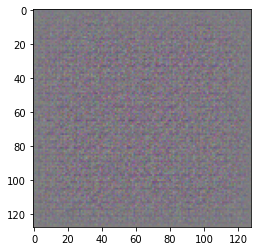

In [10]:
# look at Z = g.Z.Z
to_plot = g([3]).data.cpu().numpy().squeeze().transpose((1, 2, 0))
plt.imshow(np.clip(to_plot, 0, 1))

In [11]:
epoch_for_pre = 240
g, Z = pre_train(epoch_for_pre, 
                 train_loader, 
                 g, 
                 Z,
                 train_image_index,
                 optimizer, 
                 pre_decoder,
                  "./low_shots_pk/checkpoint/current_decoder_pre.pt")

Pre-train Epoch: 40 	 Average Loss: 0.011369
Pre-train Epoch: 80 	 Average Loss: 0.007694
Pre-train Epoch: 120 	 Average Loss: 0.006450
Pre-train Epoch: 160 	 Average Loss: 0.005420
Pre-train Epoch: 200 	 Average Loss: 0.004197
Pre-train Epoch: 240 	 Average Loss: 0.002145


In [12]:
Z

tensor([[[ 0.3530,  0.8148,  0.1707,  ..., -0.7537, -0.9999,  0.9842]],

        [[ 0.1130,  0.5802,  0.9948,  ..., -0.9951,  0.3885,  0.9930]],

        [[-0.6735, -0.9957,  0.6671,  ...,  0.9960, -0.9906, -0.8674]],

        ...,

        [[-0.0177,  0.3833, -0.6857,  ..., -0.9939,  0.9968, -0.9303]],

        [[-0.2489,  0.7402, -0.4189,  ...,  0.0085,  0.9959,  0.9959]],

        [[ 1.0000,  0.1757, -0.1953,  ..., -0.1052,  0.9989, -0.9997]]],
       device='cuda:0', grad_fn=<IndexPutBackward>)

In [13]:
g.Z.Z

Parameter containing:
tensor([[[ 0.3530,  0.8148,  0.1707,  ..., -0.7537, -0.9999,  0.9842]],

        [[ 0.1130,  0.5802,  0.9948,  ..., -0.9951,  0.3885,  0.9930]],

        [[-0.6735, -0.9957,  0.6671,  ...,  0.9960, -0.9906, -0.8674]],

        ...,

        [[-0.0177,  0.3833, -0.6857,  ..., -0.9939,  0.9968, -0.9303]],

        [[-0.2489,  0.7402, -0.4189,  ...,  0.0085,  0.9959,  0.9959]],

        [[ 1.0000,  0.1757, -0.1953,  ..., -0.1052,  0.9989, -0.9997]]],
       device='cuda:0', requires_grad=True)

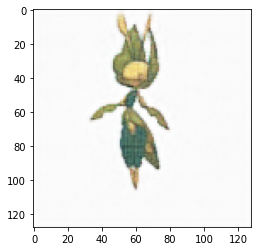

In [14]:
# prepare for train_z: 
# train_decoder needs to load in the pre-trained network params
train_decoder = Decoder(code_dim).to(device)
train_decoder.load_state_dict(torch.load("./low_shots_pk/checkpoint/current_decoder_pre.pt"))
img = train_decoder(g.Z.Z[3])

to_plot = g([3]).data.cpu().numpy().squeeze().transpose((1, 2, 0))
plt.imshow(to_plot)

In [15]:
# prepare for training
# sample inital target_z from low shots Z (already saved)
Z_hat = Z.view((24, 128)).data.cpu().numpy()

mu = np.mean(Z_hat, axis=0)
var = np.cov(Z_hat.T)
target_z = np.reshape(np.random.multivariate_normal(mu, var), (1, code_dim)).astype(np.float32)
target_z = torch.tensor(target_z, requires_grad=True).to(device)

In [16]:
# construct the training model
LV_target_z = LatentVariables(target_z).to(device)
train_g = CombinedModel(LV_target_z, train_decoder).to(device)
print(get_n_params(train_g))
train_g

13245440


CombinedModel(
  (Z): LatentVariables()
  (Decoder): Decoder(
    (dcnn): Sequential(
      (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(128, 64, 

torch.float32 [2]


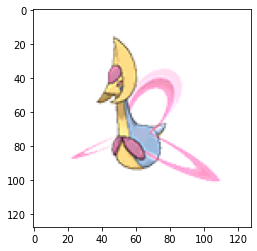

In [17]:
epoch_for_train_z = 1250 # 1250

it = iter(val_loader)
Xi_val, _, idx_val = next(it) # Xi_val: [1, 3, 128, 128]
Xi_val, _, idx_val = next(it)
Xi_val, _, idx_val = next(it)
Xi_val = Variable(Xi_val).to(device)

plt.imshow(Xi_val.cpu().numpy().squeeze().transpose(1, 2, 0))
print(Xi_val.dtype, idx_val.numpy())

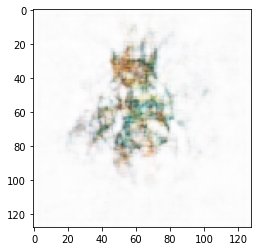

In [18]:
# before training train_g
plt.imshow(train_g([0]).detach().cpu().numpy().squeeze().transpose(1, 2, 0))

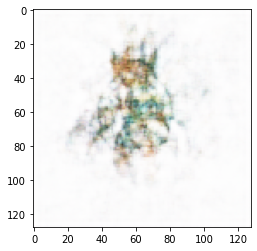

In [19]:
initial_z = target_z.clone()
plt.imshow(train_decoder(initial_z).detach().cpu().numpy().squeeze().transpose(1, 2, 0))

In [20]:
epoch_for_train_z = 1250
target_z_hat, _ = train( epoch_for_train_z, 
                         Xi_val, 
                         train_g, 
                         train_decoder, 
                         target_z, 
                         joint_train=False,
                         learning_rate=5 * 1e-4,
                         save_path="./low_shots_pk/checkpoint/current_checkpoint_train_z.pt")

In [21]:
target_z

tensor([[ 0.0587, -0.1616, -0.0125, -0.0341,  0.1040,  0.0204,  0.0597, -0.2108,
          0.0795, -0.0051,  0.0080,  0.1296,  0.0349, -0.0015, -0.0932,  0.0902,
         -0.0287, -0.0005,  0.0469,  0.0636,  0.0539,  0.0588, -0.0266,  0.1179,
          0.0185, -0.0326,  0.0691, -0.0349, -0.0195, -0.0319, -0.0146, -0.0201,
          0.1099,  0.0503, -0.0258,  0.0498,  0.1441,  0.0557,  0.0423,  0.0447,
         -0.0844, -0.1041, -0.0849,  0.0307, -0.0314, -0.0489,  0.0114, -0.1307,
          0.0899, -0.0579,  0.0410, -0.0539, -0.0806,  0.0200,  0.1084,  0.0913,
         -0.0629,  0.1167,  0.0126, -0.1023,  0.0057, -0.1503, -0.0369,  0.0244,
          0.0986,  0.0202,  0.1454, -0.0475,  0.0049, -0.0757,  0.1636, -0.0066,
          0.1574,  0.0772, -0.0865, -0.0420, -0.0790, -0.0849,  0.1183,  0.0005,
          0.0299,  0.0988, -0.0256,  0.1161,  0.0316,  0.1299,  0.0785,  0.0549,
          0.0616, -0.0488,  0.1182, -0.1843,  0.1319, -0.0051, -0.0637, -0.0714,
         -0.1589, -0.1976,  

In [22]:
train_g.Z.Z # find the optimized z_hat

Parameter containing:
tensor([[ 0.0587, -0.1616, -0.0125, -0.0341,  0.1040,  0.0204,  0.0597, -0.2108,
          0.0795, -0.0051,  0.0080,  0.1296,  0.0349, -0.0015, -0.0932,  0.0902,
         -0.0287, -0.0005,  0.0469,  0.0636,  0.0539,  0.0588, -0.0266,  0.1179,
          0.0185, -0.0326,  0.0691, -0.0349, -0.0195, -0.0319, -0.0146, -0.0201,
          0.1099,  0.0503, -0.0258,  0.0498,  0.1441,  0.0557,  0.0423,  0.0447,
         -0.0844, -0.1041, -0.0849,  0.0307, -0.0314, -0.0489,  0.0114, -0.1307,
          0.0899, -0.0579,  0.0410, -0.0539, -0.0806,  0.0200,  0.1084,  0.0913,
         -0.0629,  0.1167,  0.0126, -0.1023,  0.0057, -0.1503, -0.0369,  0.0244,
          0.0986,  0.0202,  0.1454, -0.0475,  0.0049, -0.0757,  0.1636, -0.0066,
          0.1574,  0.0772, -0.0865, -0.0420, -0.0790, -0.0849,  0.1183,  0.0005,
          0.0299,  0.0988, -0.0256,  0.1161,  0.0316,  0.1299,  0.0785,  0.0549,
          0.0616, -0.0488,  0.1182, -0.1843,  0.1319, -0.0051, -0.0637, -0.0714,
      

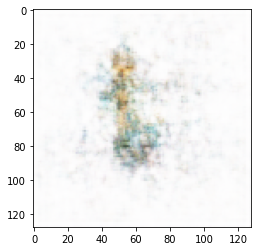

In [23]:
# try image reconstruction after phase one
img_to_val = train_decoder(target_z_hat) # img_to_val = train_g(idx_val), equivalent
to_plot = img_to_val.data.cpu().numpy().squeeze().transpose((1, 2, 0))
plt.imshow(to_plot)

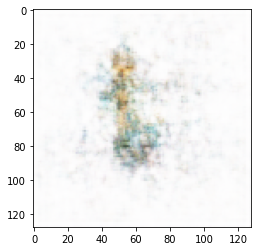

In [26]:
img_to_val = train_g([0])

to_plot = img_to_val.data.cpu().numpy().squeeze().transpose((1, 2, 0))
plt.imshow(to_plot)

In [34]:
# reconstruct the network (last phase)
warm_start_z = LatentVariables(target_z_hat).to(device)
joint_train_g = CombinedModel(warm_start_z, train_decoder).to(device)
print(get_n_params(joint_train_g))
# print(joint_train_g)

for param in train_decoder.parameters():
    param.requires_grad = False
    
# give number of trainable params
print(sum(p.numel() for p in joint_train_g.parameters() if p.requires_grad))

for param in train_decoder.parameters():
    param.requires_grad = True

13245440
128


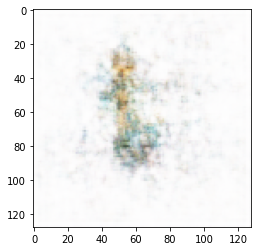

In [36]:
img_to_val = joint_train_g([0]) 
to_plot = img_to_val.data.cpu().numpy().squeeze().transpose((1, 2, 0))
plt.imshow(to_plot) # check it's already loaded

In [37]:
epoch_for_joint_train = 350
target_z_hat, G_z_hat = train(
                         epoch_for_joint_train, 
                         Xi_val, 
                         joint_train_g,
                         train_decoder, 
                         target_z_hat, 
                         joint_train=True,
                         learning_rate=1e-4,
                         save_path="./low_shots_pk/checkpoint/current_checkpoint_final.pt")

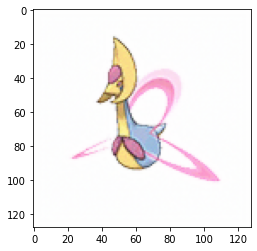

In [39]:
img_to_val = joint_train_g([0]) 
to_plot = img_to_val.data.cpu().numpy().squeeze().transpose((1, 2, 0))
plt.imshow(to_plot) # check it's already loaded